In [1]:
from src.model import PyTradeShifts
import numpy as np
import matplotlib.pyplot as plt
from src.utils import get_distance_matrix
from scipy.stats import linregress
import os

data_dir = os.path.join(os.path.dirname(os.getcwd()))
os.chdir(data_dir)


def _get_matrices():
    """Get trade and distance matrices for the global wheat trade in 2018."""
    Wheat2018 = PyTradeShifts(
        "Wheat",
        2018,
        region="Global",
        testing=True,
        make_plot=False,
    )
    Wheat2018.load_data()
    Wheat2018.remove_net_zero_countries()
    Wheat2018.prebalance()
    Wheat2018.correct_reexports()
    np.fill_diagonal(Wheat2018.trade_matrix.values, 0)

    dm = get_distance_matrix(
        Wheat2018.trade_matrix.index, Wheat2018.trade_matrix.columns
    )
    return Wheat2018.trade_matrix, dm

In [2]:
tm, dm = _get_matrices()
# a little melting trick, this will produce:
# a df with three columns: country A, country B, volume of trade from A to B
tm = tm.stack().reset_index()
# a df with three columns: country A, country B, distance from A to B
dm = dm.stack().reset_index()
# index order should match because tm and dm should have the same index/columns
# so we can just take the values and roll with it
# otherwise we should do a formal join here
y = tm[0].values
x = dm[0].values
# filter out zeroes
x = x[y != 0]
y = y[y != 0]
# sort values by distance
y = y[x.argsort()]
x = x[x.argsort()]

Loaded data for Wheat in Y2018.
Removed 0 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.


We use the approach from [Karpiarz et al.](https://arxiv.org/pdf/1409.5963.pdf) (Fig. 1), since it is beyond the scope of our work to assess and validate the (well-established) gravity model.

We do not trouble ourselves with questioning whether it is or isn't a "proper" power-law etc., we only focus on obtaining comparible quantities to the work present in the above paper.

For a more advanced approach to power-law fitting see [Clauset et al.](https://arxiv.org/pdf/0706.1062.pdf)


/home/luka/.conda/envs/pytradeshifts/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/luka/.conda/envs/pytradeshifts/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/luka/.conda/envs/pytradeshifts/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/luka/.conda/envs/pytradeshifts/lib/python3.12/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/luka/.conda/envs/pytradeshifts/lib/python3.12/site-packages/numpy/lib/function_base.py:1259: RuntimeWarning: divide by zero encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple

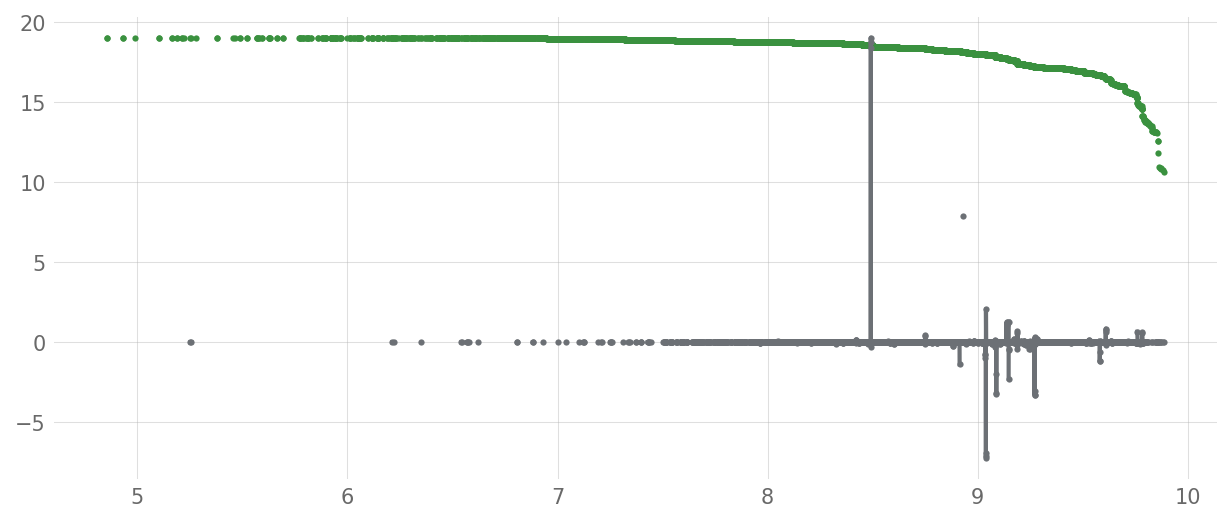

In [3]:
# integrate over distance
vr = np.cumsum(y)[::-1]
# convert to log-log
x = np.log(x)
vr = np.log(vr)
plt.plot(x, vr, ".")
# this part kind of needs to be done by hand (eye)
# we use the second derivative as the guide
# the second derivative close to zero indicates (local) linearity
d1 = np.gradient(vr, x)
d2 = np.gradient(d1, x)
# scale the derivative to make comparison easier
d2 /= np.max(d2[~np.isnan(d2)])
d2 *= np.max(vr)
plt.plot(x, d2, ".-")
plt.show()

2804 0.8947335558777068 0.8304317218117174


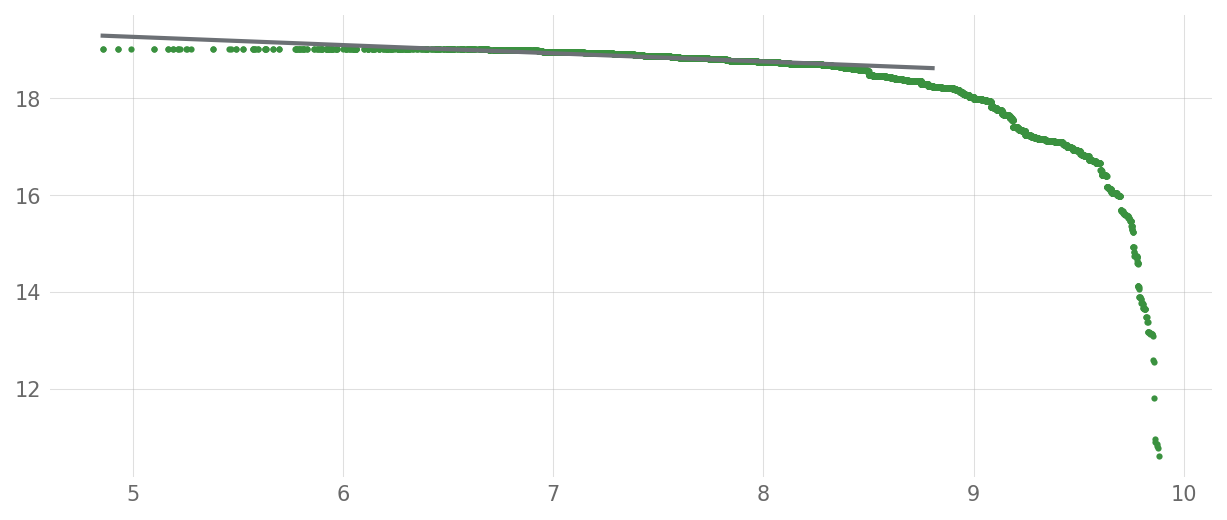

In [4]:
# find the best fit in a reasonable range assessed from the above plot
# in theory we could run this for each possible segment (computationally insane)
# but a) we want to start from index 0 (we're interested in highest trade volume the most)
# and b) we need to make sure we do not take too few points, becasue we risk overfitting
best_r = 0
best_a = 0
best_b = 0
best_end_of_lin = 0
for end_of_lin in np.arange(100, 4001, 1):
    slope, intercept, r, p, stderr = linregress(x[0:end_of_lin], vr[0:end_of_lin])
    if r**2 > best_r:
        best_r = r**2
        best_a = slope
        best_b = intercept
        best_end_of_lin = end_of_lin

# print the result, we print a+1 because the slope fitted to the integral
# is a - 1 where a is the coefficient in the trade data
print(best_end_of_lin, best_r, best_a+1)
# plot the fit alongside data
plt.plot(x, vr, ".")
plt.plot(x[0:end_of_lin], best_a * x[0:end_of_lin] + best_b, "-")
plt.show()

The fit isn't perfect but it almost never is (and honestly shouldn't be, this distribution is not exactly a power-law).

What's interesting is that the ceofficient is much lower than for all trade (which is what usually is considered).

We're finding a = 0.83 whilst in Karpiarz et al., it's in range [1.2, 1.6]